In [1]:
!python --version
!nvcc --version

# Installer l'extension CUDA pour Jupyter
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpf40bvpzq".


In [2]:
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h

--2024-12-30 21:23:30--  https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283010 (276K) [text/plain]
Saving to: ‘stb_image.h’

stb_image.h         100%[===================>] 276.38K  --.-KB/s    in 0.03s   

2024-12-30 21:23:30 (10.3 MB/s) - ‘stb_image.h’ saved [283010/283010]

--2024-12-30 21:23:30--  https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71221 (70K) [text/plain]
Saving to: ‘stb_image_

In [6]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "/content/stb_image.h"
#include "/content/stb_image_write.h"
#include <math.h>

__constant__ int N;

__global__ void otsu_segmentation(unsigned char *image, int n, unsigned char *imageResult, int *histogram, float *moyennes, float *weights, float *caracteristiques, int *threshold) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if (idx < n) {
        atomicAdd(&histogram[image[idx]], 1);
    }
    __syncthreads();

    // Calcul des caractéristiques de l'histogramme
    int tid = threadIdx.x;
    if (tid < 256) {
        float total = 0.0f, sumB = 0.0f, maxVariance = 0.0f;
        int totalPixels = 0, bestThreshold = 0;

        for (int i = 0; i < 256; ++i) {
            total += i * histogram[i];
            totalPixels += histogram[i];
        }

        float weightB = 0.0f, weightF = 0.0f;
        for (int t = 0; t < 256; ++t) {
            weightB += histogram[t];
            if (weightB == 0) continue;

            weightF = totalPixels - weightB;
            if (weightF == 0) break;

            sumB += t * histogram[t];
            float meanB = sumB / weightB;
            float meanF = (total - sumB) / weightF;

            float betweenVar = weightB * weightF * powf(meanB - meanF, 2);
            if (betweenVar > maxVariance) {
                maxVariance = betweenVar;
                bestThreshold = t;
            }
        }

        if (tid == 0) {
            *threshold = bestThreshold;
        }
    }
    __syncthreads();

    // Appliquer le seuil à l'image
    if (idx < n) {
        imageResult[idx] = (image[idx] > *threshold) ? 255 : 0;
    }
}

void resize_image(const unsigned char *input, unsigned char *output, int old_width, int old_height, int new_width, int new_height) {
    for (int y = 0; y < new_height; ++y) {
        for (int x = 0; x < new_width; ++x) {
            int src_x = x * old_width / new_width;
            int src_y = y * old_height / new_height;
            output[y * new_width + x] = input[src_y * old_width + src_x];
        }
    }
}

int main() {
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    int width, height, channels;
    unsigned char *image = stbi_load("/content/images.png", &width, &height, &channels, 1);
    if (image == NULL) {
        printf("Erreur lors du chargement de l'image\n");
        return 1;
    }

    const int factors[] = {1, 5, 10, 15, 20, 25, 30};
    const int num_factors = sizeof(factors) / sizeof(factors[0]);

    for (int i = 0; i < num_factors; ++i) {
        int factor = factors[i];
        int new_width = width * factor;
        int new_height = height * factor;
        int n = new_width * new_height;

        unsigned char *resized_image = (unsigned char *)malloc(n * sizeof(unsigned char));
        resize_image(image, resized_image, width, height, new_width, new_height);

        unsigned char *h_imageResult = (unsigned char *)malloc(n * sizeof(unsigned char));
        unsigned char *d_image, *d_imageResult;
        int *d_histogram, *d_threshold;
        float *moyennes, *weights, *caracteristiques;

        cudaMalloc((void**)&d_image, n * sizeof(unsigned char));
        cudaMalloc((void**)&d_imageResult, n * sizeof(unsigned char));
        cudaMalloc((void**)&d_histogram, 256 * sizeof(int));
        cudaMalloc((void**)&d_threshold, sizeof(int));
        cudaMalloc((void**)&moyennes, 255 * 2 * sizeof(float));
        cudaMalloc((void**)&weights, 255 * 2 * sizeof(float));
        cudaMalloc((void**)&caracteristiques, 255 * sizeof(float));

        cudaMemcpy(d_image, resized_image, n * sizeof(unsigned char), cudaMemcpyHostToDevice);
        cudaMemset(d_histogram, 0, 256 * sizeof(int));

        int blockSize = 256;
        int numBlocks = (n + blockSize - 1) / blockSize;

        // Initialiser N
        cudaMemcpyToSymbol(N, &n, sizeof(int));

        cudaEventRecord(start, 0);
        otsu_segmentation<<<numBlocks, blockSize>>>(d_image, n, d_imageResult, d_histogram, moyennes, weights, caracteristiques, d_threshold);
        cudaEventRecord(stop, 0);
        cudaEventSynchronize(stop);

        float time = 0;
        cudaEventElapsedTime(&time, start, stop);

        int h_threshold;
        cudaMemcpy(&h_threshold, d_threshold, sizeof(int), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_imageResult, d_imageResult, n * sizeof(unsigned char), cudaMemcpyDeviceToHost);

        printf("Facteur %d : Temps d'exécution : %.3f ms, Seuil trouvé : %d\n", factor, time, h_threshold);

        char output_filename[50];
        sprintf(output_filename, "/content/otsu_segmented_factor_%d.png", factor);
        stbi_write_png(output_filename, new_width, new_height, 1, h_imageResult, new_width);

        free(resized_image);
        free(h_imageResult);
        cudaFree(d_image);
        cudaFree(d_imageResult);
        cudaFree(d_histogram);
        cudaFree(d_threshold);
        cudaFree(moyennes);
        cudaFree(weights);
        cudaFree(caracteristiques);
    }

    stbi_image_free(image);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Facteur 1 : Temps d'exécution : 0.843 ms, Seuil trouvé : 188
Facteur 5 : Temps d'exécution : 14.046 ms, Seuil trouvé : 189
Facteur 10 : Temps d'exécution : 55.914 ms, Seuil trouvé : 188
Facteur 15 : Temps d'exécution : 120.444 ms, Seuil trouvé : 188
Facteur 20 : Temps d'exécution : 168.554 ms, Seuil trouvé : 254
Facteur 25 : Temps d'exécution : 265.408 ms, Seuil trouvé : 254
Facteur 30 : Temps d'exécution : 375.300 ms, Seuil trouvé : 254



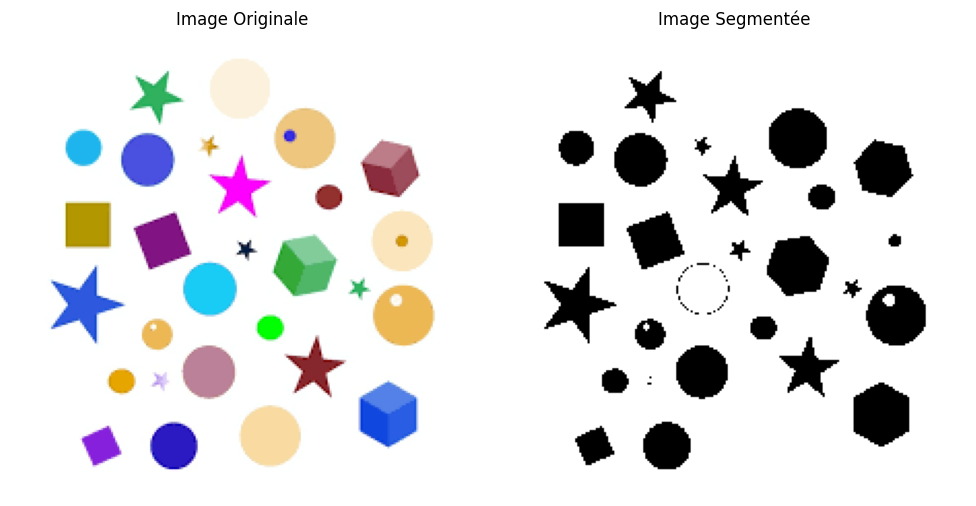

In [2]:
import os
import matplotlib.pyplot as plt
import cv2

# Charger les images
original_image = cv2.imread(os.path.join("../../images.png"))  # Remplace par le nom de ton image originale
segmented_image = cv2.imread(os.path.join("otsu_segmented_parallel.png"), cv2.IMREAD_GRAYSCALE)  # Remplace par le nom de ton image segmentée

# Vérifier si les images ont été chargées correctement
if original_image is None or segmented_image is None:
    print("Erreur de chargement des images. Vérifie les chemins des fichiers.")
else:
    # Affichage des deux images avec matplotlib
    plt.figure(figsize=(10, 5))

    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Image Originale")
    plt.axis('off')

    # Afficher l'image segmentée
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title("Image Segmentée")
    plt.axis('off')

    # Afficher la figure
    plt.tight_layout()
    plt.show()
